In [1]:
import os
import zipfile
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

ImportError: cannot import name 'float8_e4m3b11fnuz' from 'tensorflow.python.framework.dtypes' (C:\Users\Sandhya Ramachandra\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\framework\dtypes.py)

In [36]:
# Directories
image_dir = 'D:/ganesh/4-2/Front-end/dataset'
bullying_dir = os.path.join(image_dir, 'bullying')
non_bullying_dir = os.path.join(image_dir, 'non_bullying')

In [37]:
def load_and_preprocess_images(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        if file_path.lower().endswith(('.png', '.jpg', '.jpeg')):
            # Read the image
            img = cv2.imread(file_path)
            if img is not None:
                # Resize the image to 224x224 pixels (standard size for many models)
                img_resized = cv2.resize(img, (224, 224))
                # Normalize pixel values to be between 0 and 1
                img_normalized = img_resized / 255.0
                images.append(img_normalized)
                labels.append(label)
    return images, labels

In [38]:
# Load images from both classes
bullying_images, bullying_labels = load_and_preprocess_images(bullying_dir, 1)  # Label 1 for bullying
non_bullying_images, non_bullying_labels = load_and_preprocess_images(non_bullying_dir, 0)  # Label 0 for non_bullying

In [39]:
# Combine the data
images = bullying_images + non_bullying_images
labels = bullying_labels + non_bullying_labels

# Convert to NumPy arrays
X = np.array(images)
y = np.array(labels)

# Shuffle the dataset
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=42)

In [40]:
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [41]:
# Load base model
base_model = keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze the base model

# Build the model
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)  # Binary classification

model = keras.Model(inputs, outputs)

In [42]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [43]:
# Define training parameters
epochs = 5
batch_size = 8

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size
)

Epoch 1/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 31s 376ms/step - accuracy: 0.5399 - loss: 0.8026 - val_accuracy: 0.6979 - val_loss: 0.5396
Epoch 2/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 294ms/step - accuracy: 0.6990 - loss: 0.5827 - val_accuracy: 0.7812 - val_loss: 0.4745
Epoch 3/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 287ms/step - accuracy: 0.8083 - loss: 0.4409 - val_accuracy: 0.7917 - val_loss: 0.4688
Epoch 4/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 289ms/step - accuracy: 0.8655 - loss: 0.3746 - val_accuracy: 0.8333 - val_loss: 0.4169
Epoch 5/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 312ms/step - accuracy: 0.8901 - loss: 0.3150 - val_accuracy: 0.8229 - val_loss: 0.4093


In [44]:
# Evaluate on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8138 - loss: 0.4278
Validation Loss: 0.4093
Validation Accuracy: 0.8229


In [46]:
model.save('cnn_model.keras')

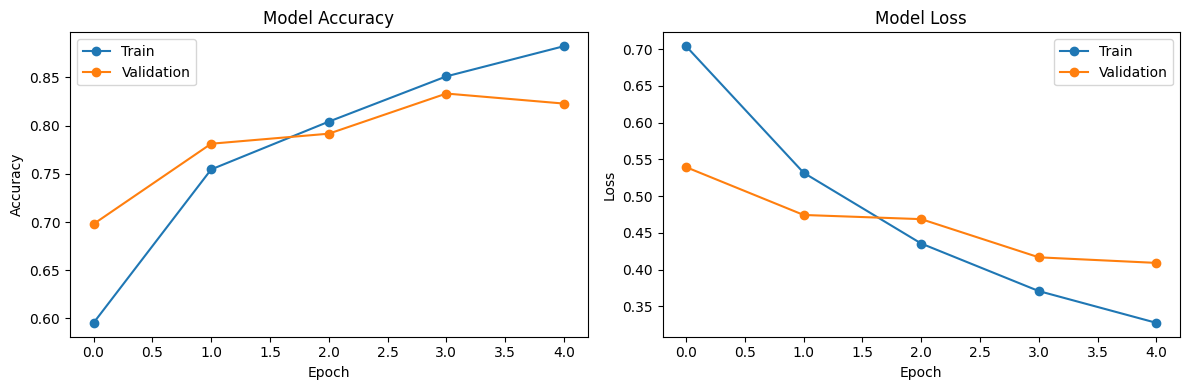

In [47]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train', marker='o')
plt.plot(history.history['val_loss'], label='Validation', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [48]:
loaded_model = keras.models.load_model('cnn_model.keras')

In [49]:
def predict_image(image_path):
    # Read the image
    img = cv2.imread(image_path)
    if img is not None:
        # Preprocess the image
        img_resized = cv2.resize(img, (224, 224))
        img_normalized = img_resized / 255.0
        img_input = np.expand_dims(img_normalized, axis=0)
        # Make prediction
        prediction = loaded_model.predict(img_input)
        probability = prediction[0][0]
        label = 'Bullying' if probability >= 0.5 else 'Non-Bullying'
        print(f"Prediction: {label}")
    else:
        print("Image not found or unable to read.")

In [50]:
# Example image paths (update with actual paths to your test images)
test_image_bullying = 'dataset/bullying/1.jpg'
test_image_non_bullying = 'dataset/non_bullying/255.jpg'

# Predict on a bullying image
predict_image(test_image_bullying)

# Predict on a non-bullying image
predict_image(test_image_non_bullying)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Prediction: Bullying
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Prediction: Non-Bullying


In [51]:
def predict_image(image_path):
    # Read the image
    img = cv2.imread(image_path)
    if img is not None:
        # Preprocess the image
        img_resized = cv2.resize(img, (224, 224))
        img_normalized = img_resized / 255.0
        img_input = np.expand_dims(img_normalized, axis=0)
        # Make prediction
        prediction = loaded_model.predict(img_input)
        probability = prediction[0][0]
        label = 'Bullying' if probability >= 0.5 else 'Non-Bullying'
        print(f"Prediction: {label}")
    else:
        print("Image not found or unable to read.")

In [52]:
# Example image paths (update with actual paths to your test images)
test_image = 'dataset/bullying/1.jpg'


# Predict on a image
predict_image(test_image)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
Prediction: Bullying
